# Conditional Variational Autoencoder in Keras 

http://wiseodd.github.io/techblog/2016/12/17/conditional-vae/


In [1]:
from tensorflow.examples.tutorials.mnist import input_data
from keras.layers import Input, Dense, Lambda, merge
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf


m = 50   # minibatch size?
n_z = 2  # dimention of latent space
n_epoch = 30

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

X_train, y_train = mnist.train.images, mnist.train.labels
X_test, y_test = mnist.test.images, mnist.test.labels

n_x = X_train.shape[1] # 784
n_y = y_train.shape[1] # 10

print n_x,  n_y

# Q(z|X) -- encoder
X = Input(batch_shape=(m, n_x)) # size of MNIST images
cond = Input(batch_shape=(m, n_y))

inputs = merge([X, cond], mode='concat', concat_axis=1)
h_q = Dense(512, activation='relu')(inputs)
mu = Dense(n_z, activation='linear')(h_q)
log_sigma = Dense(n_z, activation='linear')(h_q)

def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., std=1.)
    return mu + K.exp(log_sigma / 2.) * eps

z = Lambda(sample_z)([mu, log_sigma])
z_cond = merge([z, cond], mode='concat', concat_axis=1) # <--- NEW!

Using TensorFlow backend.


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
784 10


In [2]:
# P(X|z) -- decoder
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(784, activation='sigmoid')

h_p = decoder_hidden(z_cond)
outputs = decoder_out(h_p)

In [3]:
# Overall VAE model, for reconstruction and training
vae = Model([X, cond], outputs)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model([X, cond], mu)

# Generator model, generate new data given latent variable z
d_cond = Input(shape=(n_y,))
d_z = Input(shape=(n_z,))
d_inputs = merge([d_z, d_cond], mode='concat', concat_axis=1)
d_h = decoder_hidden(d_inputs)
d_out = decoder_out(d_h)
decoder = Model([d_z, d_cond], d_out)

In [4]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for eatch data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed from as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)
    
    return recon + kl

In [6]:
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit([X_train, y_train], X_train, batch_size=m, nb_epoch=200, validation_split=0.1)

Train on 49500 samples, validate on 5500 samples
Epoch 1/200
49500/49500 [==============================] - 15s - loss: 137.9083 - val_loss: 135.6084
Epoch 2/200
49500/49500 [==============================] - 14s - loss: 136.5206 - val_loss: 134.5766
Epoch 3/200
49500/49500 [==============================] - 14s - loss: 135.6138 - val_loss: 134.0674
Epoch 4/200
49500/49500 [==============================] - 14s - loss: 134.8819 - val_loss: 133.3267
Epoch 5/200
49500/49500 [==============================] - 14s - loss: 134.3215 - val_loss: 132.8428
Epoch 6/200
49500/49500 [==============================] - 14s - loss: 133.8154 - val_loss: 132.5298
Epoch 7/200
49500/49500 [==============================] - 14s - loss: 133.4274 - val_loss: 132.2938
Epoch 8/200
49500/49500 [==============================] - 15s - loss: 133.1127 - val_loss: 131.8600
Epoch 9/200
49500/49500 [==============================] - 15s - loss: 132.7737 - val_loss: 131.6924
Epoch 10/200
49500/49500 [================

49500/49500 [==============================] - 14s - loss: 127.4751 - val_loss: 129.9477
Epoch 81/200
49500/49500 [==============================] - 14s - loss: 127.4536 - val_loss: 130.0634
Epoch 82/200
49500/49500 [==============================] - 14s - loss: 127.3850 - val_loss: 130.2444
Epoch 83/200
49500/49500 [==============================] - 14s - loss: 127.3811 - val_loss: 130.0860
Epoch 84/200
49500/49500 [==============================] - 14s - loss: 127.3428 - val_loss: 130.0622
Epoch 85/200
49500/49500 [==============================] - 15s - loss: 127.3158 - val_loss: 129.9395
Epoch 86/200
49500/49500 [==============================] - 14s - loss: 127.2645 - val_loss: 130.0771
Epoch 87/200
49500/49500 [==============================] - 14s - loss: 127.2725 - val_loss: 130.0237
Epoch 88/200
49500/49500 [==============================] - 14s - loss: 127.2277 - val_loss: 130.0852
Epoch 89/200
49500/49500 [==============================] - 14s - loss: 127.2238 - val_loss: 13

49500/49500 [==============================] - 15s - loss: 125.9728 - val_loss: 130.7757
Epoch 160/200
49500/49500 [==============================] - 14s - loss: 125.9602 - val_loss: 130.9115
Epoch 161/200
49500/49500 [==============================] - 14s - loss: 125.9162 - val_loss: 131.0202
Epoch 162/200
49500/49500 [==============================] - 14s - loss: 125.9007 - val_loss: 131.1456
Epoch 163/200
49500/49500 [==============================] - 14s - loss: 125.9119 - val_loss: 131.1405
Epoch 164/200
49500/49500 [==============================] - 14s - loss: 125.9154 - val_loss: 130.8137
Epoch 165/200
49500/49500 [==============================] - 14s - loss: 125.9073 - val_loss: 131.0335
Epoch 166/200
49500/49500 [==============================] - 14s - loss: 125.8582 - val_loss: 131.1667
Epoch 167/200
49500/49500 [==============================] - 14s - loss: 125.8601 - val_loss: 131.3358
Epoch 168/200
49500/49500 [==============================] - 14s - loss: 125.8280 - val

Training history


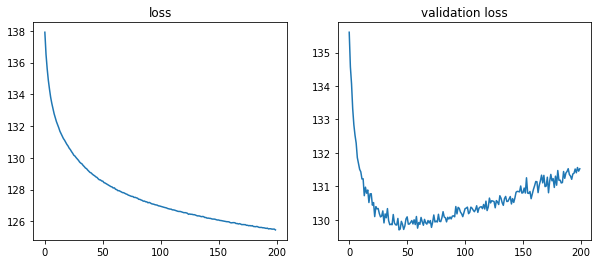

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

print "Training history"
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(vae.history.history['loss'])
ax1.set_title('loss')
ax2 = fig.add_subplot(1, 2, 2)
plt.plot(vae.history.history['val_loss'])
ax2.set_title('validation loss')

## random Z / conditioning with 0-9

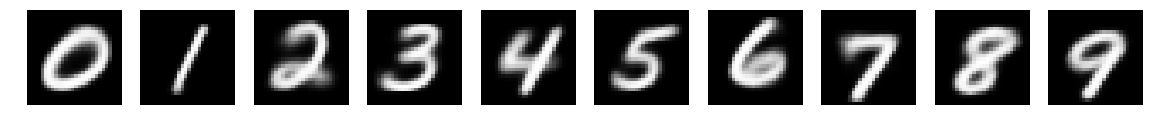

In [8]:
from keras.utils import np_utils
digit_size = 28

z_sample = np.random.rand(1, 2) # random 

plt.figure(figsize=(20, 2))
for i in range(10):
    c = np_utils.to_categorical(i,n_y)
    x_decoded = decoder.predict([z_sample, c])
    digit = x_decoded[0].reshape(digit_size, digit_size)

    plt.subplot(1, n_y, i+1)
    plt.axis('off')
    plt.imshow(digit, cmap='Greys_r',)
plt.show()

## conditioning with numbers (0-9) / interpolating Z

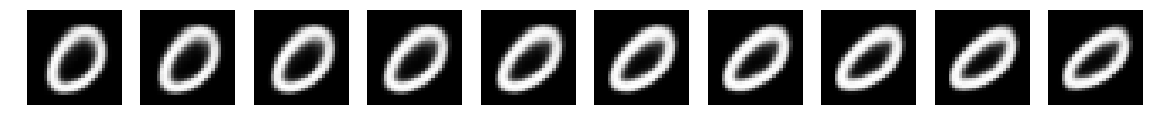

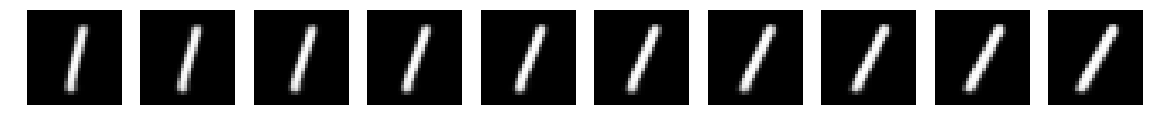

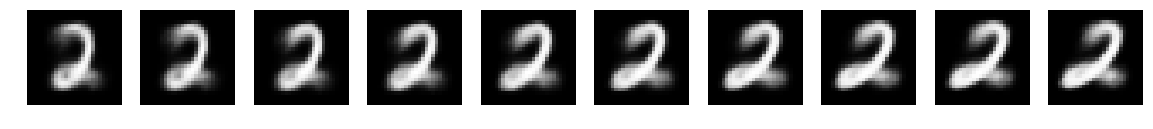

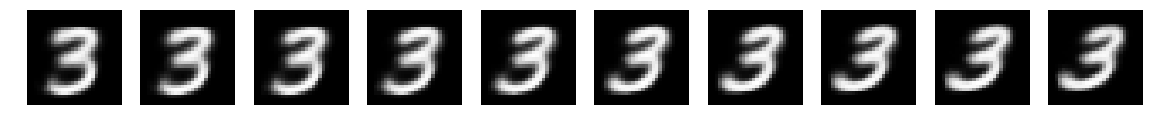

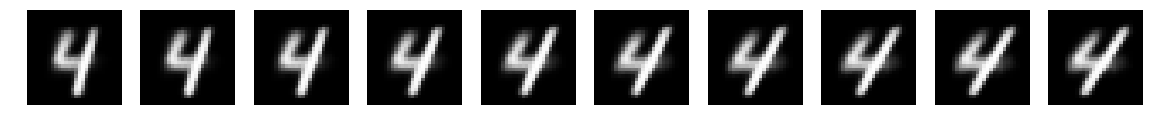

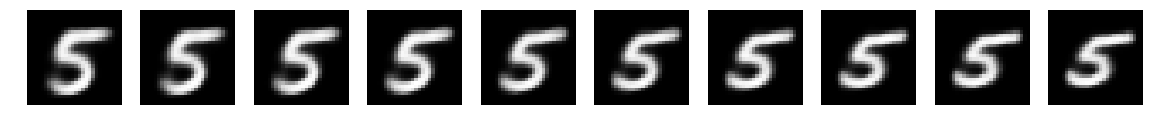

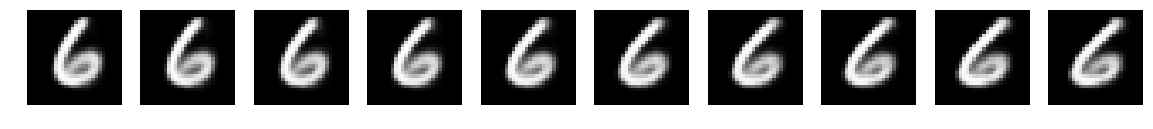

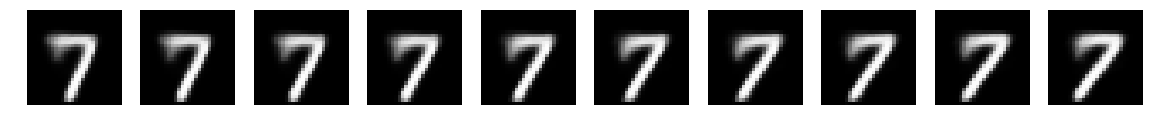

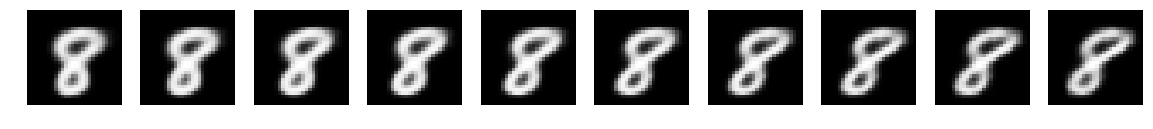

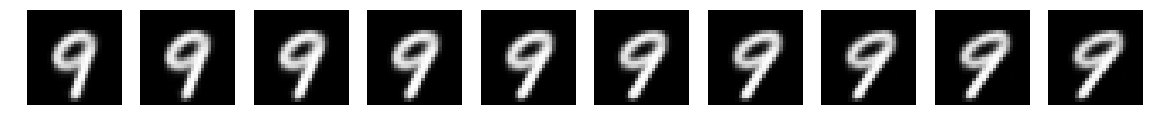

In [18]:
for j in range(10):
    c = np_utils.to_categorical(j,n_y)

    plt.figure(figsize=(20, 2))
    for i in range(10):
        z_sample = np.array([[0.1 * i, 0.1*i]])
        x_decoded = decoder.predict([z_sample, c])
        digit = x_decoded[0].reshape(digit_size, digit_size)

        plt.subplot(1, n_y, i+1)
        plt.axis('off')
        plt.imshow(digit, cmap='Greys_r',)
plt.show()